# Logistic Regression

使用句子里所有词的平均embedding作为模型的特征，然后进行训练Linear Regressor

In [1]:
import pandas as pd
import os
import time
import gc
import numpy as np
import random
from tqdm.notebook import tqdm
from keras.preprocessing import text, sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
import torch
from torch import nn
from torch.utils import data
from torch.nn import functional as F
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

2024-06-24 15:23:46.169570: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
# disable progress bars when submitting
def is_interactive():
   return 'SHLVL' not in os.environ

if not is_interactive():
    def nop(it, *a, **k):
        return it

    tqdm = nop

In [3]:
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

In [ ]:
MAX_LEN = 220

def preprocess(data):
    '''
    Credit goes to https://www.kaggle.com/gpreda/jigsaw-fast-compact-solution
    '''
    punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~`" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'
    def clean_special_chars(text, punct):
        for p in punct:
            text = text.replace(p, ' ')
        return text

    data = data.astype(str).apply(lambda x: clean_special_chars(x, punct))
    return data

max_features = None

train = pd.read_csv('../dataset/train.csv')
# test = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/test.csv')

x_train = preprocess(train['comment_text'])
y_train = np.where(train['target'] >= 0.5, 1, 0)
y_aux_train = train[['target', 'severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat']]

In [ ]:
# 均衡化数据集
# 确定数量较少的类别
count_class_0 = np.sum(y_train == 0)
count_class_1 = np.sum(y_train == 1)

# 从数量较多的类别中随机抽样
index_class_0 = np.where(y_train == 0)[0]
index_class_1 = np.where(y_train == 1)[0]

# 从数量较多的类别中随机选择与数量较少的类别相同数量的样本
seed_everything()
selected_index_class_0 = np.random.choice(index_class_0, count_class_1, replace=False)

# 构建平衡的数据集
x_train = np.concatenate([x_train[selected_index_class_0], x_train[index_class_1]])
y_train = np.concatenate([y_train[selected_index_class_0], y_train[index_class_1]])
y_aux_train = np.concatenate([y_aux_train.iloc[selected_index_class_0], y_aux_train.iloc[index_class_1]])


In [ ]:
# 划分训练集和测试集，按照9:1的比例
x_train, x_test, y_train, y_test, y_aux_train, y_aux_test = train_test_split(
    x_train, y_train, y_aux_train, test_size=0.1, random_state=1624)

tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(list(x_train) + list(x_test))

x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)
x_train = pad_sequences(x_train, maxlen=MAX_LEN)
x_test = pad_sequences(x_test, maxlen=MAX_LEN)

max_features = max_features or len(tokenizer.word_index) + 1
max_features

122578

In [ ]:
x_train_torch = torch.tensor(x_train, dtype=torch.long).cuda()
x_test_torch = torch.tensor(x_test, dtype=torch.long).cuda()
y_train_torch = torch.tensor(np.hstack([y_train[:, np.newaxis], y_aux_train]), dtype=torch.float32).cuda()
y_train_baseline = torch.tensor(y_train, dtype=torch.float32).cuda()

In [ ]:
CRAWL_EMBEDDING_PATH = '../WordEmbedding/crawl-300d-2M.vec'
GLOVE_EMBEDDING_PATH = '../WordEmbedding/glove.840B.300d.txt'

def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')

def load_embeddings(path):
    with open(path) as f:
        return dict(get_coefs(*line.strip().split(' ')) for line in tqdm(f))

def build_matrix(word_index, path):
    embedding_index = load_embeddings(path)
    embedding_matrix = np.zeros((len(word_index) + 1, 300))
    unknown_words = []
    
    for word, i in word_index.items():
        try:
            embedding_matrix[i] = embedding_index[word]
        except KeyError:
            unknown_words.append(word)
    return embedding_matrix, unknown_words

In [ ]:
crawl_matrix, unknown_words_crawl = build_matrix(tokenizer.word_index, CRAWL_EMBEDDING_PATH)
print('n unknown words (crawl): ', len(unknown_words_crawl))

glove_matrix, unknown_words_glove = build_matrix(tokenizer.word_index, GLOVE_EMBEDDING_PATH)
print('n unknown words (glove): ', len(unknown_words_glove))

n unknown words (crawl):  38008
n unknown words (glove):  36611


In [ ]:
embedding_matrix = np.concatenate([crawl_matrix, glove_matrix], axis=-1)
embedding_matrix.shape

del crawl_matrix
del glove_matrix
gc.collect()

0

In [ ]:
train_dataset = data.TensorDataset(x_train_torch, y_train_baseline)
test_dataset = data.TensorDataset(x_test_torch)

基本上所有任务都以这里的train_dataset和test_dataset作为输入！！！！！

2. 模型训练——对于每个模型，都应分成multitask和非multitask两种情况进行训练。

大部分现成代码并没有绘制出loss曲线，请在训练时注意画图，画图部分可参考我已经训练完的模型。【如果训练模型的时间很长，请把训练中的loss变化写入一个csv文件，方便后面分析】——至少也要每个epoch打印出平均的loss

在这个部分，出于取巧的思路，大家可以选择原先就使用了multi-task的方法。然后把他输入所有y（y_label+y_aux_label）的地方，换成y_label【可能还需要调整部分代码】，就可以实现有没有multitask的对比

训练完模型后，请保存为pth文件（方便后面进行ensemble learning的探究）。


In [ ]:
#在初始化模型的时候，一定要加入embedding_matrix！！！（train和test数据集需要在输入模型后进一步转化成embedding）
class SpatialDropout(nn.Dropout2d):
    def forward(self, x):
        x = x.unsqueeze(2)    # (N, T, 1, K)
        x = x.permute(0, 3, 2, 1)  # (N, K, 1, T)
        x = super(SpatialDropout, self).forward(x)  # (N, K, 1, T), some features are masked
        x = x.permute(0, 3, 2, 1)  # (N, T, 1, K)
        x = x.squeeze(2)  # (N, T, K)
        return x
    
class NeuralNet(nn.Module):
    def __init__(self, embedding_matrix):
        super(NeuralNet, self).__init__()
        embed_size = embedding_matrix.shape[1]
        
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        # self.embedding_dropout = SpatialDropout(0.3)
        
        self.linear = nn.Linear(embed_size, 1)  # 线性层
        self.sigmoid = nn.Sigmoid()  # sigmoid激活函数
        
    def forward(self, x):
        h_embedding = self.embedding(x)
        # h_embedding = self.embedding_dropout(h_embedding)
        h_embedding = torch.mean(h_embedding, dim=1)
        
        out = self.linear(h_embedding)
        out = self.sigmoid(out)
        return out
    


In [ ]:
def train_model(model, train, test, loss_fn, output_dim, lr=0.1,
                batch_size=512, n_epochs=30,
                enable_checkpoint_ensemble=True):
    param_lrs = [{'params': param, 'lr': lr} for param in model.parameters()]
    optimizer = torch.optim.Adam(param_lrs, lr=lr)

    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: 0.8 ** epoch)
    
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False)
    all_test_preds = []
    checkpoint_weights = [2 ** epoch for epoch in range(n_epochs)]
    
    train_losses = []
    
    for epoch in range(n_epochs):
        start_time = time.time()
        
        scheduler.step()
        
        model.train()
        avg_loss = 0.
        # Signal = True
        for data in tqdm(train_loader, disable=False):
            x_batch = data[:-1]
            y_batch = data[-1]
            
            y_pred = model(*x_batch)            
            loss = loss_fn(y_pred.squeeze(1),y_batch.squeeze(1))
            # if Signal:
            #     print(y_batch)
            #     print(y_pred)
            #     Signal = False

            optimizer.zero_grad()
            loss.backward()

            optimizer.step()
            avg_loss += loss.item() / len(train_loader)
        train_losses.append(avg_loss)
            
        model.eval()
        test_preds = np.zeros((len(test),1))
    
        for i, x_batch in enumerate(test_loader):
            y_pred = model(*x_batch).detach().cpu().numpy()

            test_preds[i * batch_size:(i+1) * batch_size] = y_pred

        all_test_preds.append(test_preds)
        elapsed_time = time.time() - start_time
        print('Epoch {}/{} \t loss={:.4f} \t time={:.2f}s'.format(
              epoch + 1, n_epochs, avg_loss, elapsed_time))

    if enable_checkpoint_ensemble:
        test_preds = np.average(all_test_preds, weights=checkpoint_weights, axis=0)    
    else:
        test_preds = all_test_preds[-1]
     # Plot the training loss curve
    plt.plot(train_losses)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.show()
        
    return test_preds,model

Model  0


/root/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 1/30 	 loss=1556.0855 	 time=2.39s
Epoch 2/30 	 loss=1547.6551 	 time=2.29s
Epoch 3/30 	 loss=1545.7352 	 time=2.28s
Epoch 4/30 	 loss=1544.7373 	 time=2.25s
Epoch 5/30 	 loss=1544.0863 	 time=2.20s
Epoch 6/30 	 loss=1543.6906 	 time=2.27s
Epoch 7/30 	 loss=1543.3438 	 time=2.26s
Epoch 8/30 	 loss=1543.1221 	 time=2.07s
Epoch 9/30 	 loss=1542.9232 	 time=2.28s
Epoch 10/30 	 loss=1542.7736 	 time=2.28s
Epoch 11/30 	 loss=1542.6717 	 time=2.06s
Epoch 12/30 	 loss=1542.5457 	 time=2.28s
Epoch 13/30 	 loss=1542.4682 	 time=2.28s
Epoch 14/30 	 loss=1542.4042 	 time=2.07s
Epoch 15/30 	 loss=1542.3325 	 time=2.28s
Epoch 16/30 	 loss=1542.2608 	 time=2.28s
Epoch 17/30 	 loss=1542.2386 	 time=2.32s
Epoch 18/30 	 loss=1542.1892 	 time=2.07s
Epoch 19/30 	 loss=1542.1504 	 time=2.41s
Epoch 20/30 	 loss=1542.1273 	 time=2.27s
Epoch 21/30 	 loss=1542.0871 	 time=2.07s
Epoch 22/30 	 loss=1542.0536 	 time=2.29s
Epoch 23/30 	 loss=1542.0118 	 time=2.27s
Epoch 24/30 	 loss=1542.0139 	 time=2.27s
E

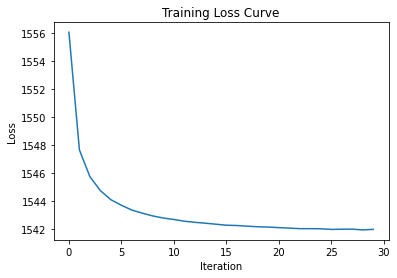


Model  1
Epoch 1/30 	 loss=1555.7793 	 time=2.13s
Epoch 2/30 	 loss=1547.5191 	 time=2.49s
Epoch 3/30 	 loss=1545.6099 	 time=2.45s
Epoch 4/30 	 loss=1544.7067 	 time=2.11s
Epoch 5/30 	 loss=1544.0136 	 time=2.37s
Epoch 6/30 	 loss=1543.6559 	 time=2.33s
Epoch 7/30 	 loss=1543.3519 	 time=2.11s
Epoch 8/30 	 loss=1543.0942 	 time=2.27s
Epoch 9/30 	 loss=1542.9530 	 time=2.27s
Epoch 10/30 	 loss=1542.7506 	 time=2.26s
Epoch 11/30 	 loss=1542.6267 	 time=2.08s
Epoch 12/30 	 loss=1542.5801 	 time=2.35s
Epoch 13/30 	 loss=1542.4501 	 time=2.29s
Epoch 14/30 	 loss=1542.3921 	 time=2.09s
Epoch 15/30 	 loss=1542.3244 	 time=2.28s
Epoch 16/30 	 loss=1542.2678 	 time=2.28s
Epoch 17/30 	 loss=1542.2253 	 time=2.27s
Epoch 18/30 	 loss=1542.1682 	 time=2.08s
Epoch 19/30 	 loss=1542.1368 	 time=2.28s
Epoch 20/30 	 loss=1542.0763 	 time=2.29s
Epoch 21/30 	 loss=1542.0680 	 time=2.23s
Epoch 22/30 	 loss=1542.0515 	 time=2.53s
Epoch 23/30 	 loss=1542.0232 	 time=2.40s
Epoch 24/30 	 loss=1542.0112 	 ti

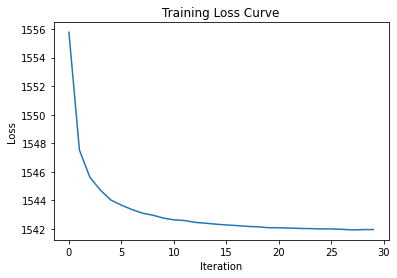

In [ ]:
train_dataset = data.TensorDataset(x_train_torch, y_train_baseline.reshape(-1,1))
test_dataset = data.TensorDataset(x_test_torch)

all_test_preds = []

for model_idx in range(2):
    print('Model ', model_idx)
    seed_everything(1234 + model_idx)
    
    model = NeuralNet(embedding_matrix)
    model.cuda()
    
    test_preds,model = train_model(model, train_dataset, test_dataset, output_dim=y_train_baseline.shape[-1], 
                             loss_fn=nn.CrossEntropyLoss())
    torch.save(model.state_dict(), f'LR Baseline model{model_idx}.pth')
    all_test_preds.append(test_preds)
    print()

In [ ]:
from sklearn.metrics import confusion_matrix
NUM_MODELS = 2
for model_idx in range(NUM_MODELS):
    preds = np.where(all_test_preds[model_idx]>0.5,1,0)
    cm = confusion_matrix(y_test, preds)
    # 输出混淆矩阵
    print(f"Confusion Matrix of Model {model_idx}:")
    print(cm)
    print(f'acc of model{model_idx} = ',(cm[0][0]+cm[1][1])/sum(sum(cm)))

ensemble_preds = np.zeros(y_test.shape)
for model_idx in range(NUM_MODELS):
    ensemble_preds += all_test_preds[model_idx].squeeze(1)
ensemble_preds /= NUM_MODELS

cm = confusion_matrix(y_test, np.where(ensemble_preds>0.5,1,0))
# 输出混淆矩阵
print(f"Confusion Matrix of Ensemble Model:")
print(cm)
print(f'acc of ensemble model = ',np.sum(np.where(ensemble_preds>0.5,1,0)==y_test)/preds.shape[0])



Confusion Matrix of Model 0:
[[11374  3128]
 [ 1997 12368]]
acc of model0 =  0.8224616343922125
Confusion Matrix of Model 1:
[[11450  3052]
 [ 2056 12309]]
acc of model1 =  0.8230505421415457
Confusion Matrix of Ensemble Model:
[[11414  3088]
 [ 2014 12351]]
acc of ensemble model =  0.823258391935428
